In [583]:
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from umap import UMAP
from sentence_transformers import SentenceTransformer

from sklearn.metrics import f1_score

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import math

import spacy

# Models

In [584]:
class Model:

    def __init__(self, dataset_name: str) -> None:
        self.dataset_name = dataset_name

        self.documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
        self.documents_df = self.documents_df

        self.documents = self.documents_df['document'].tolist()
        self.labels = self.documents_df['class_name'].tolist()

        self.num_topics = len(set(self.labels))
        self.random_n_iter = 1
        self.limit_words_comparison = 1000

    def train(self) -> None:
        """ Train the model """
        raise NotImplementedError
    
    def get_words_for_topics(self, topics: list):
        """ Get the words for each topic from the documents

        Args:
            topics (list): The topics for each document

        Returns:
            dict: The words for each topic
        """
        words_by_topics = {}
        for idx, topic in enumerate(topics):
            words = self.documents_df.iloc[idx]['document'].split()

            if topic not in words_by_topics:
                words_by_topics[topic] = {}

            for word in words:
                if word not in words_by_topics[topic]:
                    words_by_topics[topic][word] = 0

                words_by_topics[topic][word] += 1

        # Transform the inner dicts into list sorted by the number of occurrences
        for topic in words_by_topics:
            words_by_topics[topic] = sorted(words_by_topics[topic].items(), key=lambda x: x[1], reverse=True)
            words_by_topics[topic] = [word for word in words_by_topics[topic]]
            words_by_topics[topic] = words_by_topics[topic][:self.limit_words_comparison]

        return words_by_topics
    
    def compute_similarity(self, true_words: list, extracted_words: list) -> float:
        similarity = 0
        total_count = 0

        for true_word, true_word_count in true_words:
            same_word_extracted_count = 0
            for extracted_word, extracted_word_count in extracted_words:
                if true_word == extracted_word:
                    same_word_extracted_count = extracted_word_count
                    break

            current_similarity = 1 - abs(true_word_count - same_word_extracted_count) / max(true_word_count, same_word_extracted_count)
            current_similarity *= (true_word_count + same_word_extracted_count)
            similarity += current_similarity

            total_count += true_word_count + same_word_extracted_count

        return similarity / total_count
    
    def assign_topics(self, y_pred: list) -> dict:
        """ Assign extracted topics to true topics

        Args:
            y_pred (list): extracted topics

        Returns:
            dict: true topic associated to each extracted topic
        """
        words_by_extracted_topics = self.get_words_for_topics(y_pred)
        words_by_true_topics = self.get_words_for_topics(self.labels)

        similarity_matrix = []
        for _, extracted_topic in enumerate(words_by_extracted_topics):
            row = []
            for _, true_topic in enumerate(words_by_true_topics):
                row.append(self.compute_similarity(words_by_true_topics[true_topic], words_by_extracted_topics[extracted_topic]))
            similarity_matrix.append(row)

        # Find the assignment of extracted topics to true topics in an iterative way
        assignment = {}
        assignment_similarity = {}

        flat_similarity_matrix = [item for sublist in similarity_matrix for item in sublist]
        sorted_flat_similarity_matrix = sorted(flat_similarity_matrix)

        already_assigned_true_topics = []
        already_assigned_extracted_topics = []

        true_topic_labels = list(words_by_true_topics.keys())
        extracted_topic_labels = list(words_by_extracted_topics.keys())

        while len(assignment) < len(words_by_extracted_topics):
            current_assigned_true_topic = None
            current_assigned_extracted_topic = None
            highest_value = None
            current_highest_value_idx = (len(similarity_matrix) * len(similarity_matrix)) - 1

            while (current_assigned_extracted_topic in already_assigned_extracted_topics or current_assigned_extracted_topic is None) or (current_assigned_true_topic in already_assigned_true_topics or current_assigned_true_topic is None):
                highest_value = sorted_flat_similarity_matrix[current_highest_value_idx]

                idx_in_flat_matrix = flat_similarity_matrix.index(highest_value)
                row_idx_highest_value_in_matrix = math.floor(idx_in_flat_matrix / len(similarity_matrix))
                col_idx_highest_value_in_matrix = idx_in_flat_matrix % len(similarity_matrix)

                current_assigned_true_topic = true_topic_labels[row_idx_highest_value_in_matrix]
                current_assigned_extracted_topic = extracted_topic_labels[col_idx_highest_value_in_matrix]

                current_highest_value_idx -= 1

            assignment[current_assigned_true_topic] = current_assigned_extracted_topic
            assignment_similarity[current_assigned_true_topic] = highest_value

            already_assigned_true_topics.append(current_assigned_true_topic)
            already_assigned_extracted_topics.append(current_assigned_extracted_topic)

        # -- Testing purpose: see the topic assignment with the words and similarity --
        print('Global assignment similarity: ', sum(assignment_similarity.values()) / len(assignment_similarity.values()))

        for idx, true_topic in enumerate(words_by_true_topics):
            print('Topic: ', true_topic)
            print('Assigned topic: ', assignment[true_topic])
            print('Similarity: ', assignment_similarity[true_topic])
            print('Extracted words: ', words_by_extracted_topics[assignment[true_topic]])
            print('True words: ', words_by_true_topics[true_topic])
            print('-------------------')

        return assignment

    def get_f1_scores(self) -> list:
        """ Evaluate the model on the train documents
        
        Returns:
            list: f1 score values
        """
        raise NotImplementedError

In [585]:
class LDAModel(Model):

    def __init__(self, dataset_name: str) -> None:
        super().__init__(dataset_name)

    def train(self) -> None:
        """ See the documentation of the parent class """
        vectorizer = CountVectorizer()
        self.X = vectorizer.fit_transform(self.documents)

        self.model = LatentDirichletAllocation(n_components=self.num_topics, random_state=0)
        self.model.fit(self.X)
    
    def get_f1_scores(self) -> list:
        """ See the documentation of the parent class """
        f1_scores = []

        y_true = self.labels

        for i in range(self.random_n_iter):
            self.train()

            y_pred = self.model.transform(self.X).argmax(axis=1)

            assignment = self.assign_topics(y_pred)
            assignment = {assignment[key]: key for key in assignment}
            y_pred = [assignment[topic] for topic in y_pred]

            f1_scores.append(f1_score(y_true, y_pred, average='macro'))

        return f1_scores

In [586]:
class BERTopicModel(Model):

    def __init__(self, dataset_name: str) -> None:
        super().__init__(dataset_name)

    def train(self) -> None:
        """ See the documentation of the parent class """

        umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=0)
        self.model = BERTopic(language="english", calculate_probabilities=True, nr_topics=self.num_topics, umap_model=umap)
        self.model.fit(self.documents)
    
    def get_f1_scores(self) -> list:
        """ See the documentation of the parent class """
        f1_scores = []

        y_true = self.labels

        for i in range(self.random_n_iter):
            self.train()

            y_pred = self.model.transform(self.documents)[0]
            y_pred = [prediction + 1 for prediction in y_pred] # Consider the topic -1 as the topic 0

            assignment = self.assign_topics(y_pred)
            assignment = {assignment[key]: key for key in assignment}
            y_pred = [assignment[topic] for topic in y_pred]

            f1_scores.append(f1_score(y_true, y_pred, average='macro'))

        return f1_scores

# Assignment example

In [587]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents_df = documents_df

documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

In [588]:
# umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=0)
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# bert_model = BERTopic(language="english", calculate_probabilities=True, nr_topics=5, umap_model=umap, embedding_model=embedding_model)
# bert_model.fit(documents)

In [589]:
def assign():
    """ Assign extracted topics to true topics 
    
    Returns:
        tuple: (true topic associated to each extracted topic, global assignment similarity)
    """
    pass

In [590]:
# pca = PCA(n_components=2)

# embeddings = bert_model.embedding_model.embedding_model.encode(documents)
# embeddings = pca.fit_transform(embeddings)

In [591]:
# embeddings_df = pd.DataFrame()
# embeddings_df['document'] = documents
# embeddings_df['embedding_1'] = embeddings[:, 0]
# embeddings_df['embedding_2'] = embeddings[:, 1]
# embeddings_df['y_true'] = labels
# embeddings_df['y_pred'] = assign()

# Evaluation

[[0.66400106 0.43697602 0.42755132 0.40464738 0.57528337]
 [0.33639265 0.95094155 0.35719867 0.32100254 0.37470972]
 [0.54786572 0.37049745 0.5189156  0.53419365 0.35864703]
 [0.40578446 0.40630439 0.88367551 0.46040284 0.37059467]
 [0.34761092 0.29892837 0.34849858 0.68032036 0.32970867]]
sport 1 0.9509415450154722 1 1
-------------------
sport 1 0.9509415450154722 1 1
business 3 0.8836755133284157 3 2
-------------------
sport 1 0.9509415450154722 1 1
business 3 0.8836755133284157 3 2
entertainment 0 0.6803203570130971 4 3
-------------------
sport 1 0.9509415450154722 1 1
business 3 0.8836755133284157 3 2
entertainment 0 0.6803203570130971 4 3
tech 2 0.6640010643016349 0 0
-------------------
sport 1 0.9509415450154722 1 1
business 3 0.8836755133284157 3 2
entertainment 0 0.6803203570130971 4 3
tech 2 0.6640010643016349 0 0
tech 4 0.5752833677828749 0 4
politics 2 0.5478657158397451 2 0
politics 0 0.5341936519914389 2 3
politics 3 0.5189155985645939 2 2
business 0 0.4604028385242142

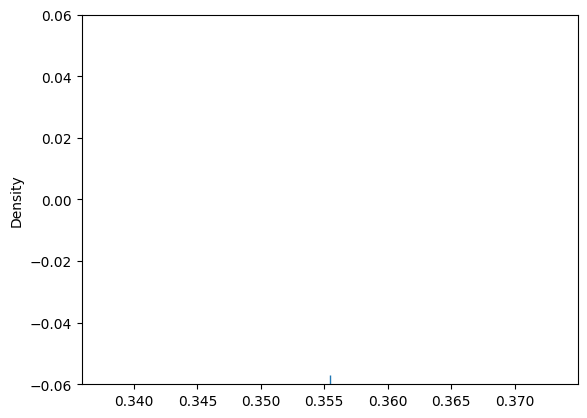

In [592]:
models = {
    'LDA': LDAModel,
    # 'BERTopic': BERTopicModel
}

datasets = ['BBC_News']

for dataset in datasets:
    for model_name, model_class in models.items():
        model = model_class(dataset_name=dataset)
        f1_scores = model.get_f1_scores()

        print(f'{model_name} {dataset}: {np.mean(f1_scores)}')

        sns.distplot(f1_scores, hist=False, rug=True, label=model_name)